In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import h5py

In [2]:
from sklearn import metrics

In [3]:
from tensorflow import keras

In [4]:
import sys

In [5]:
%load_ext autoreload
%autoreload 2


In [6]:
sys.path.append('../')

In [7]:
import datatools

In [8]:
import importlib

In [9]:
from glob import glob

In [10]:
from scipy import stats

## Load Data

In [11]:
SIM="/gpfs/slac/atlas/fs1/d/rafaeltl/public/Muon/simulation/20220912/SIG_atlas_nsw_pad_z0_xya/"
DATA_LOC=f"{SIM}/TEST/*.h5"

files=glob(DATA_LOC)

print(len(files))

200


In [12]:
data, dmat, Y, Y_mu, Y_hit, sig_keys = datatools.make_data_matrix(files, max_files=200, sort_by='z')

~~ Reading data... ~~


100%|██████████| 200/200 [00:13<00:00, 14.75it/s]


~~ Calculating occupancy information... ~~


100%|██████████| 500000/500000 [00:15<00:00, 31479.24it/s]

!!
I read 500000 events, of which 500000 have muon and 0 do not
!!


In [13]:
data.keys()

dict_keys(['ev_mu_phi', 'ev_mu_theta', 'ev_mu_time', 'ev_mu_x', 'ev_mu_y', 'ev_n_mu_signals', 'ev_n_signals', 'ev_n_noise', 'n_sig_mmx', 'n_sig_mmu', 'n_sig_mmv', 'n_sig_mm', 'n_sig_stgc', 'n_sig_mdt'])

In [14]:
data['ev_n_noise'] = data['ev_n_signals'] - data['ev_n_mu_signals']

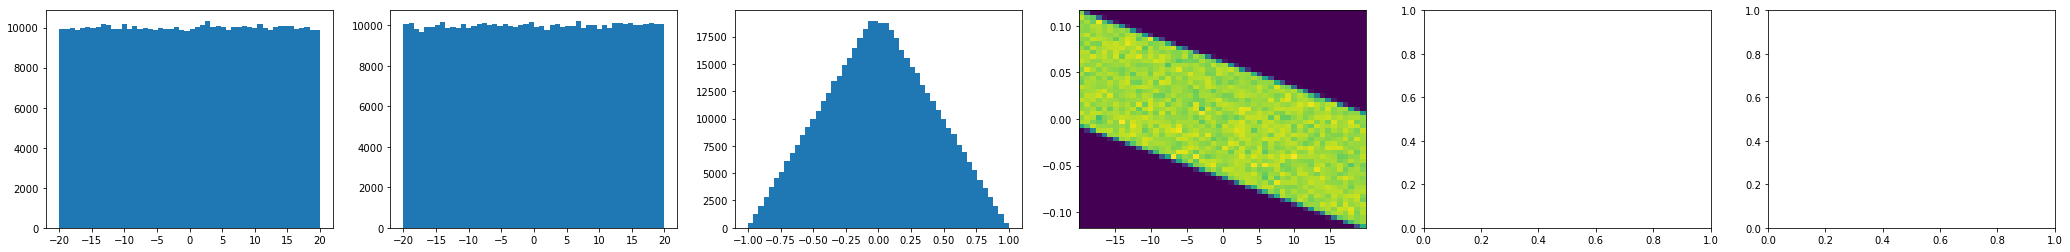

In [15]:
ncols, nrows = (6,1)
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(6*ncols,4*nrows))
axs = axs.flatten()
axs[0].hist(data['ev_mu_x'][Y_mu==1], bins=50)
axs[1].hist(data['ev_mu_y'][Y_mu==1], bins=50)
axs[2].hist(data['ev_mu_theta'][Y_mu==1]/np.max(data['ev_mu_theta'][Y_mu==1]), bins=50)
axs[3].hist2d(data['ev_mu_x'][Y_mu==1], data['ev_mu_theta'][Y_mu==1], bins=(50,50))

# axs[3].hist(data['ev_mu_x'][Y_mu==0], bins=50)
# axs[4].hist(data['ev_mu_theta'][Y_mu==0]/np.max(data['ev_mu_theta'][Y_mu==0]), bins=50)

plt.show()

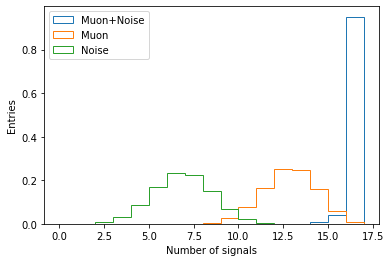

In [16]:
plt.Figure()
# plt.hist(data['ev_n_signals'][Y_mu==0], density=1, histtype='step', range=(0,17), bins=17, label='Noise')
plt.hist(data['ev_n_signals'][Y_mu==1], density=1, histtype='step', range=(0,17), bins=17, label='Muon+Noise')
plt.hist(data['ev_n_mu_signals'][Y_mu==1], density=1, histtype='step', range=(0,17), bins=17, label='Muon')
plt.hist(data['ev_n_noise'][Y_mu==1], density=1, histtype='step', range=(0,17), bins=17, label='Noise')
plt.legend(loc='upper left')
plt.xlabel('Number of signals')
plt.ylabel('Entries')
plt.show()

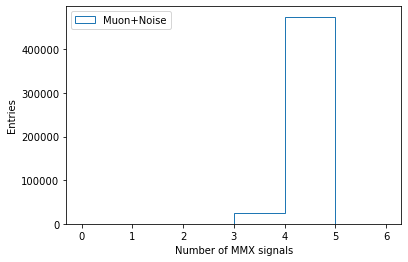

In [17]:
plt.Figure()
# h_noise = plt.hist(data['n_sig_mmx'][Y_mu==0], histtype='step', range=(0,6), bins=6, label='Noise')
h_muons = plt.hist(data['n_sig_mmx'][Y_mu==1], histtype='step', range=(0,6), bins=6, label='Muon+Noise')
plt.legend(loc='upper left')
plt.xlabel('Number of MMX signals')
plt.ylabel('Entries')
plt.show()

## Define models to compare

In [18]:
import trainingvariables

In [19]:
X_pad = datatools.training_prep(dmat, sig_keys)

~~ Preparing padded matrix ~~


100%|██████████| 500000/500000 [01:41<00:00, 4907.42it/s]

Output data matrix shape: (500000, 20, 20)


In [20]:
detmat=f"{SIM}/atlas_nsw_pad_z0.yml"
X_det = datatools.detector_matrix(dmat, sig_keys, detcard=detmat)

~~ Preparing detector-based data matrix ~~
Using detector card: /gpfs/slac/atlas/fs1/d/rafaeltl/public/Muon/simulation/20220912/SIG_atlas_nsw_pad_z0_xya//atlas_nsw_pad_z0.yml
[0, 5.1, 21.9, 27.0, 92.0, 103.5, 125.2, 125.2, 136.6, 136.6, 223.0, 223.0, 234.5, 234.5, 256.2, 267.6, 334.0, 339.1, 355.9, 361.0]


100%|██████████| 500000/500000 [02:11<00:00, 3813.60it/s]

Output data matrix shape: (500000, 20, 20)


In [21]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

linearized = True

In [22]:
import linefit

In [23]:
lfits = linefit.get_fits(dmat, sig_keys)

In [24]:
lfits

array([[-8.41583004e-03, -1.10399277e+01,  2.28895973e+03],
       [-2.47230983e-02,  1.68099609e+01,  6.44813866e+03],
       [-1.48502149e-02, -1.17001596e+00,  1.32121152e+03],
       ...,
       [-1.71644477e-04, -1.32027557e+01,  1.02198219e+03],
       [-6.35617122e-02,  1.45138103e+01,  2.97849247e+03],
       [ 4.32085346e-02, -4.28647842e+00,  1.03488768e+03]])

In [25]:
lfits_mu = linefit.get_fits(dmat, sig_keys, is_perfect=True)

In [26]:
lfits_theta = np.arctan(lfits[:,0])*1000
lfits_mu_theta = np.arctan(lfits_mu[:,0])*1000

In [27]:
# lfits_theta[np.arctan(lfits[:,0])<0] = -(lfits_theta[np.arctan(lfits[:,0])<0] + np.pi/2 )
# lfits_theta[np.arctan(lfits[:,0])>0] = -(lfits_theta[np.arctan(lfits[:,0])>0] - np.pi/2 )

# lfits_mu_theta[np.arctan(lfits_mu[:,0])<0] = -(lfits_mu_theta[np.arctan(lfits_mu[:,0])<0] + np.pi/2 )
# lfits_mu_theta[np.arctan(lfits_mu[:,0])>0] = -(lfits_mu_theta[np.arctan(lfits_mu[:,0])>0] - np.pi/2 )

In [28]:
lfits_theta

array([ -8.41563136, -24.71806298, -14.84912337, ...,  -0.17164447,
       -63.47632076,  43.18167485])

In [31]:
mod_list = [

["354",  "../withnoise_quantile_models/MyTCN_CL5.3.1.0..5.3.3.0_DLnone_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_DetMat_4Outputs"],
["354-KD",  "../models/MyTCN_CL5.4.1.0..5.4.3.0_DLnone_CBNormFalse_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_DetMat_4Outputs_LONG_BIG"],
["354",  "../withnoise_quantile_models/MyTCN_CL5.3.1.0..5.3.3.0_DLnone_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_DetMat_4Outputs_LONG"],
# ["377",  "../withnoise_quantile_models/MyTCN_CL7.4.4.0..5.3.1.0_DLnone_CBNormFalse_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_DetMat_4Outputs"],
# ["534",  "../models/MyTCN_CL5.4.1.0..5.4.1.0_DLnone_CBNormFalse_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_DetMat_4Outputs_LONG"],
# ["588",  "../withnoise_quantile_models/MyTCN_CL7.3.1.0..5.3.1.0_DLnone_CBNormFalse_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_DetMat_4Outputs"],
# ["240",  "../nonoise_quantile_models/MyTCN_CL4.3.1.0..4.3.3.0_DLnone_CBNormFalse_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_DetMat_4Outputs"],
# ["632",  "../models/MyTCN_CL7.4.1.0..5.4.1.0_DLnone_CBNormFalse_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_DetMat_4Outputs_LONG"],
# ["615",  "../models/MyTCN_CL7.4.4.0..10.3.1.0_DLnone_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_DetMat_4Outputs"],
# ["554",  "../models/MyTCN_CL5.5.1.0..5.5.1.0_DLnone_CBNormFalse_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_DetMat_4Outputs"], 
    
# ["240-kd",  "../models/MyTCN_CL4.3.1.0..4.3.3.0_DLnone_CBNormFalse_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_DetMat_4Outputs_LONG_BIG"],

["9754",  "../withnoise_quantile_models/MyTCN_CL25.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_DetMat_4Outputs"],
# ["9754",  "../nonoise_quantile_models/MyTCN_CL25.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_DetMat_4Outputs_LONG"],
["7564",  "../withnoise_quantile_models/MyTCN_CL20.4.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_DetMat_4Outputs"],
    
]
mdict = {}

for imod,mod in enumerate(mod_list):
    
    m_name = str(imod)+'_'+str(mod[0]) + '_'
    m_name += 'flat' if 'Flatten' in mod[1] else 'avg'
    m_name += 'DET' if 'DetMat' in mod[1] else ''
    
    mdict[m_name] = {
        "loc": mod[1],
        "color": f"C{len(mdict)+2}",
        "x_reg_out": 0,
        "a_reg_out": 1
    }
    

In [32]:
for mod in mdict:
    
    if 'yhat' in mdict[mod].keys():
        print("Already added this model")
        continue
    
    if 'DET' in mod:
        X_prep = X_det
    else:
        X_prep = X_pad
        
    
    vars_of_interest = np.zeros(X_prep.shape[2], dtype=bool)
    training_vars = trainingvariables.tvars
    for tv in training_vars:
        vars_of_interest[sig_keys.index(tv)] = 1
    mdict[mod]['x'] = X_prep[:,:,vars_of_interest]
    mdict[mod]['x_keys'] = np.array(sig_keys)[vars_of_interest]
    
    model = keras.models.load_model(mdict[mod]['loc'],compile=False)
    
    preds = model.predict(mdict[mod]['x'], batch_size=1024)
        
    mult_fact = max(data['ev_mu_x'])
    mult_facty = max(data['ev_mu_y'])
    mult_facta = max(data['ev_mu_theta'])
    
    all_weights = np.array([])
    for layer in model.layers:
        for w in layer.weights:
            all_weights = np.concatenate( [w.numpy().flatten(), all_weights] )
    all_weights[ np.abs(all_weights) < 2**-25] = 2**-25
    mdict[mod]['nweights'] = all_weights
    
    mdict[mod]['x_reg'] = preds[:,0]*mult_fact
    mdict[mod]['x_reg_q'] = preds[:,1]*mult_fact
    mdict[mod]['x_reg_dq'] = np.abs( mdict[mod]['x_reg'] - mdict[mod]['x_reg_q'])
    mdict[mod]['a_reg'] = preds[:,2]*mult_facta*1000
    mdict[mod]['a_reg_q'] = preds[:,3]*mult_facta*1000
    mdict[mod]['a_reg_dq'] = np.abs( mdict[mod]['a_reg'] - mdict[mod]['a_reg_q'] )*1000
    # if preds.shape[1] > 2: 
    #     mdict[mod]['y_reg'] = preds[:,2]*mult_facty

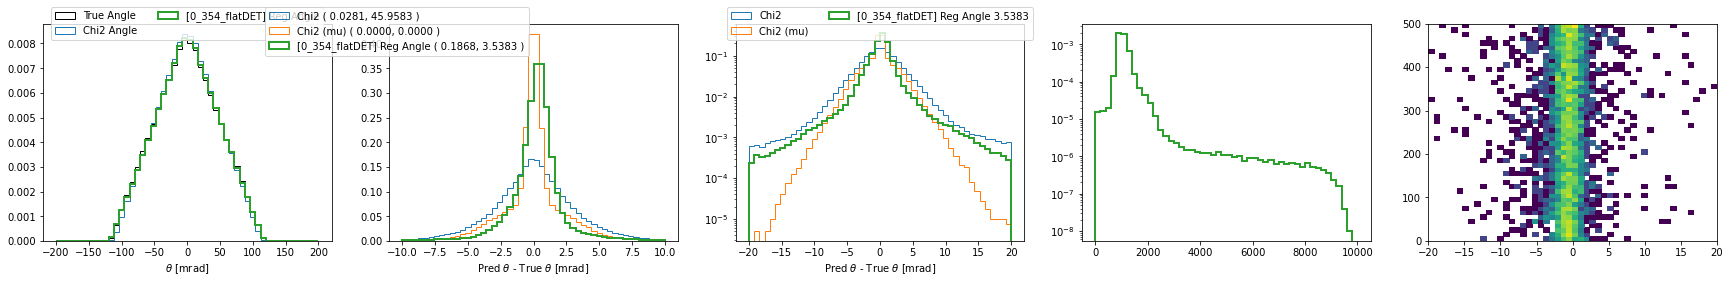

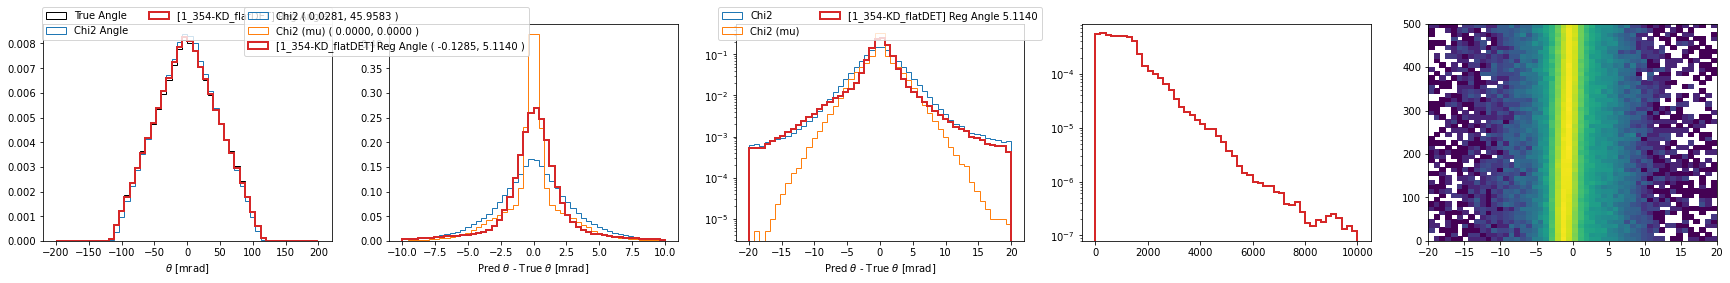

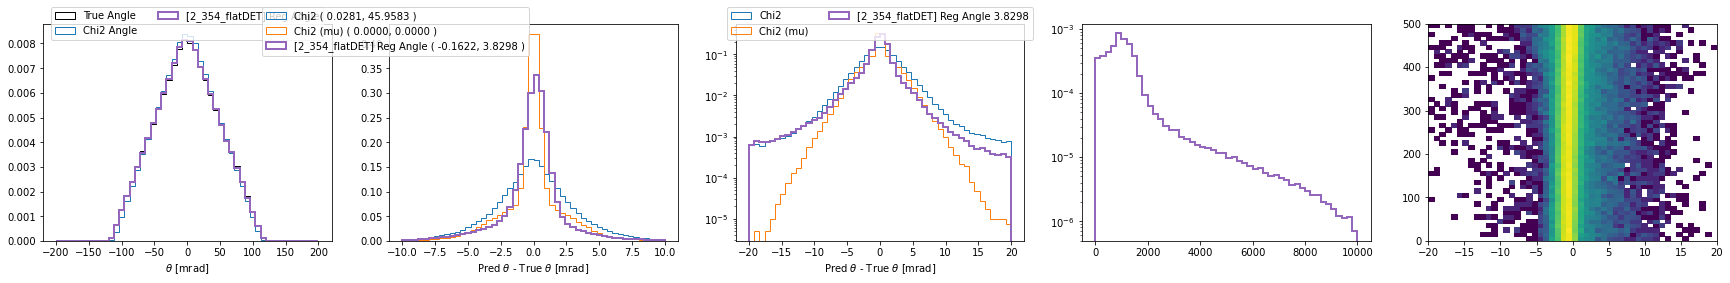

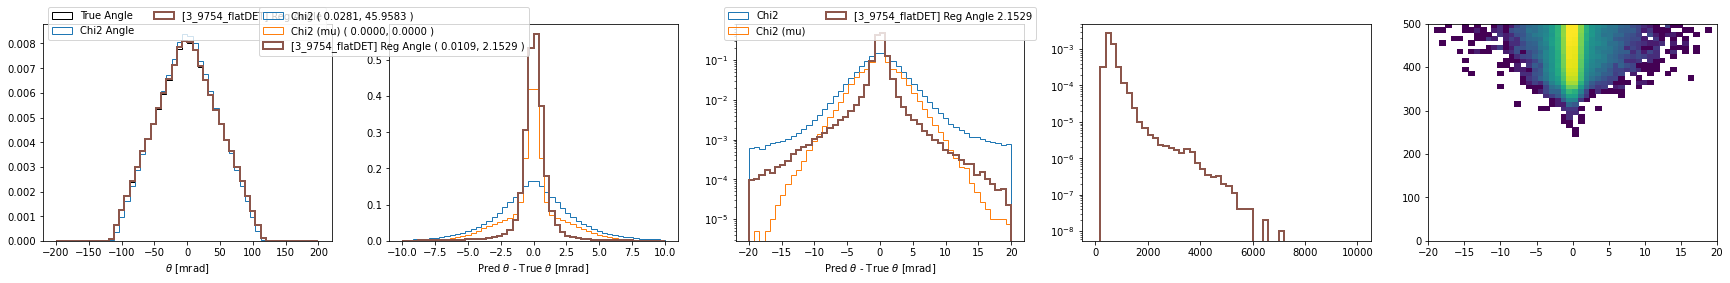

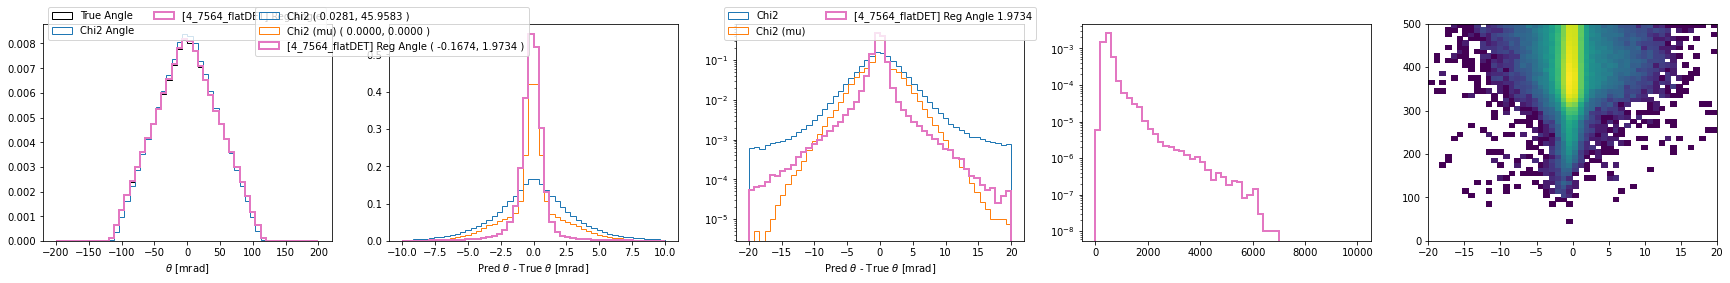

In [33]:
this_cut=(Y_mu==1)

norm_fit_chi2 = stats.norm.fit(lfits_theta[this_cut] - data['ev_mu_theta'][Y_mu==1])
norm_fit_chi2mu = [0,0]#stats.norm.fit(lfits_mu_theta[this_cut] - data['ev_mu_theta'][Y_mu==1])

for mod in mdict:
    
    ncols, nrows = (5,1)
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(6*ncols,4*nrows))
    axs = axs.flatten()

    axs[0].hist(data['ev_mu_theta'][this_cut]*1000, histtype='step', range=(-0.2*1000,0.2*1000), density=1, color='black',
                bins=50, label=f'True Angle')

    axs[0].hist(lfits_theta[this_cut], histtype='step', range=(-0.2*1000,0.2*1000), density=1, color='C0',
                bins=50, label=f'Chi2 Angle')

    # axs[0].hist(lfits_mu_theta[this_cut], histtype='step', range=(-0.2,0.2), density=1, color='C1',
    #             bins=50, label=f'Chi2 Angle (mu)')
    

    axs[1].hist(lfits_theta[this_cut] - data['ev_mu_theta'][Y_mu==1]*1000, histtype='step', range=(-0.01*1000,0.01*1000), density=1, color='C0',
                bins=50, label=f'Chi2 ( {norm_fit_chi2[0]:.4f}, {norm_fit_chi2[1]:.4f} )')

    axs[1].hist(lfits_mu_theta[this_cut] - data['ev_mu_theta'][Y_mu==1]*1000, histtype='step', range=(-0.01*1000,0.01*1000), density=1, color='C1',
                bins=50, label=f'Chi2 (mu) ( {norm_fit_chi2mu[0]:.4f}, {norm_fit_chi2mu[1]:.4f} )')

    axs[2].hist(lfits_theta[this_cut] - data['ev_mu_theta'][Y_mu==1]*1000, histtype='step', range=(-0.02*1000,0.02*1000), density=1, color='C0',
                bins=50, label=f'Chi2')

    axs[2].hist(lfits_mu_theta[this_cut] - data['ev_mu_theta'][Y_mu==1]*1000, histtype='step', range=(-0.02*1000,0.02*1000), density=1, color='C1',
                bins=50, label=f'Chi2 (mu)')

#     axs[3].hist(lfits_theta[Y_mu==0], histtype='step', range=(-0.2,0.2), density=1, color='C0',
#                 bins=50, label=f'Chi2 Angle')

#     axs[3].hist(lfits_mu_theta[Y_mu==0], histtype='step', range=(-0.2,0.2), density=1, color='C1',
#                 bins=50, label=f'Chi2 Angle (mu)')
        
    if True:
        areg=mdict[mod]['a_reg']
        axs[0].hist(areg[this_cut], histtype='step', range=(-0.2*1000,0.2*1000), bins=50, color=mdict[mod]['color'],  density=1,
                    label=f'[{mod}] Reg Angle', linewidth=2)

        norm_fit_mod = stats.norm.fit(areg[this_cut] - data['ev_mu_theta'][Y_mu==1]*1000)
        axs[1].hist(areg[this_cut] - data['ev_mu_theta'][Y_mu==1]*1000, 
                    histtype='step', range=(-0.01*1000,0.01*1000), bins=50, color=mdict[mod]['color'],  density=1,
                    label=f'[{mod}] Reg Angle ( {norm_fit_mod[0]:.4f}, {norm_fit_mod[1]:.4f} )', linewidth=2)

        this_std = (areg[this_cut] - data['ev_mu_theta'][Y_mu==1]*1000).std()
        axs[2].hist(areg[this_cut] - data['ev_mu_theta'][Y_mu==1]*1000, 
                    histtype='step', range=(-0.02*1000,0.02*1000), bins=50, color=mdict[mod]['color'],  density=1,
                    label=f'[{mod}] Reg Angle {this_std:.4f}', linewidth=2)
        
        axs[3].hist(mdict[mod]['a_reg_dq'], 
                    histtype='step', range=(0*1000,10*1000), bins=50, color=mdict[mod]['color'],  density=1,
                    label=f'[{mod}] Reg Angle', linewidth=2)
        
        axs[4].hist2d(
            areg[this_cut] - data['ev_mu_theta'][Y_mu==1]*1000,
            mdict[mod]['a_reg_dq'],
            range=( (-0.02*1000, 0.02*1000), (-0*1000, 0.5*1000)),
            bins=(50,50),
            norm=mpl.colors.LogNorm()
        
        )
        
        
    axs[0].set_xlabel(r'$\theta$ [mrad]')
    axs[1].set_xlabel(r'Pred $\theta$ - True $\theta$ [mrad]')
    axs[2].set_xlabel(r'Pred $\theta$ - True $\theta$ [mrad]')
    axs[0].legend(ncol=2, loc='upper center', bbox_to_anchor=(0.5, 1.1))
    axs[1].legend(ncol=1, loc='upper right', bbox_to_anchor=(0.5, 1.1))
    # axs[1].set_yscale('log')
    axs[2].legend(ncol=2, loc='upper center', bbox_to_anchor=(0.5, 1.1))
    axs[2].set_yscale('log')
    axs[3].set_yscale('log')
    # plt.savefig(f"plots/{mod}_reg_0.pdf")
    
    # axs[1].plot([0,0], [1e-4, 200], 'g--')
    # axs[2].plot([0,0], [1e-4, 1e3], 'g--')
    plt.show()

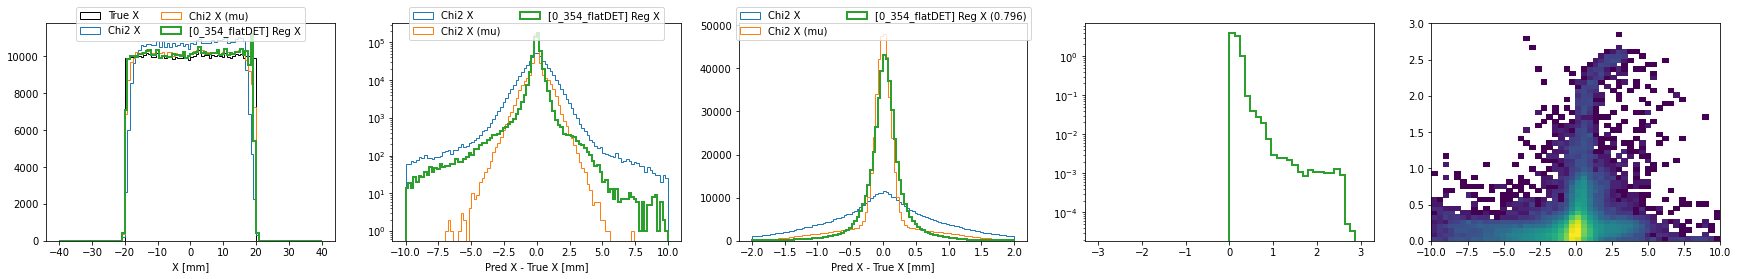

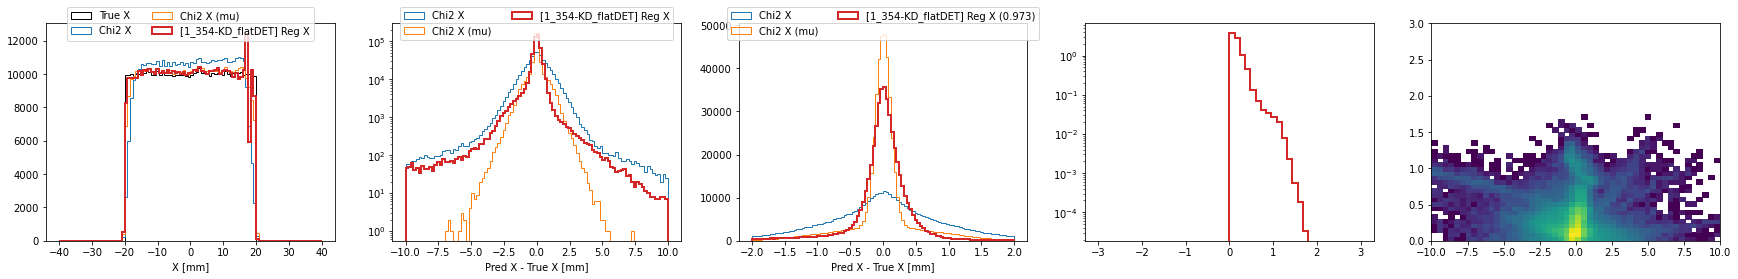

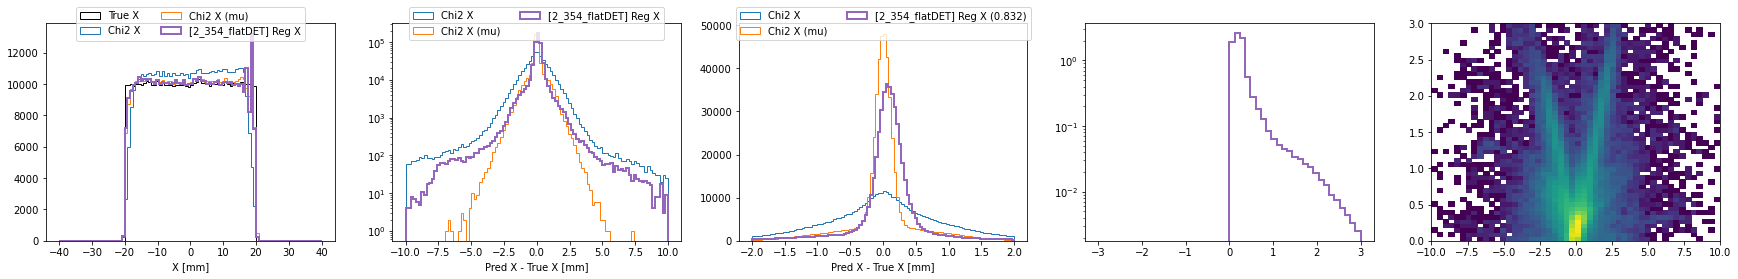

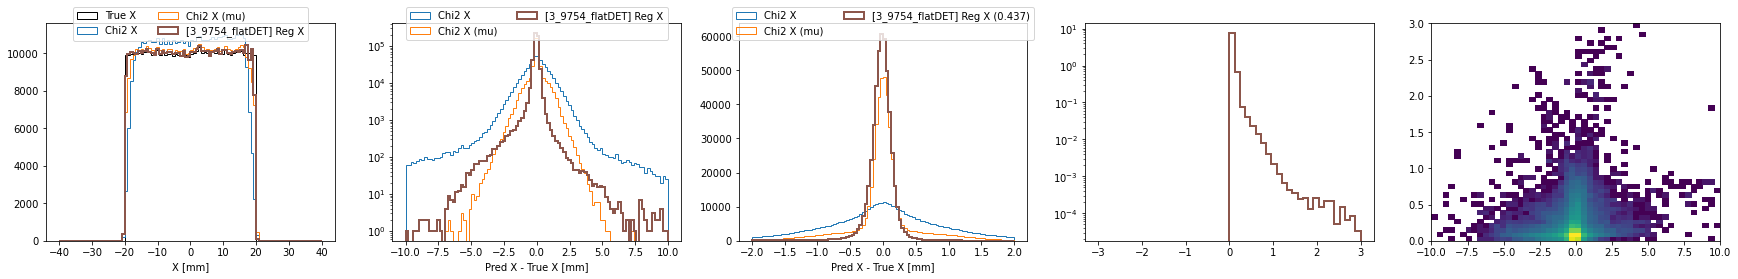

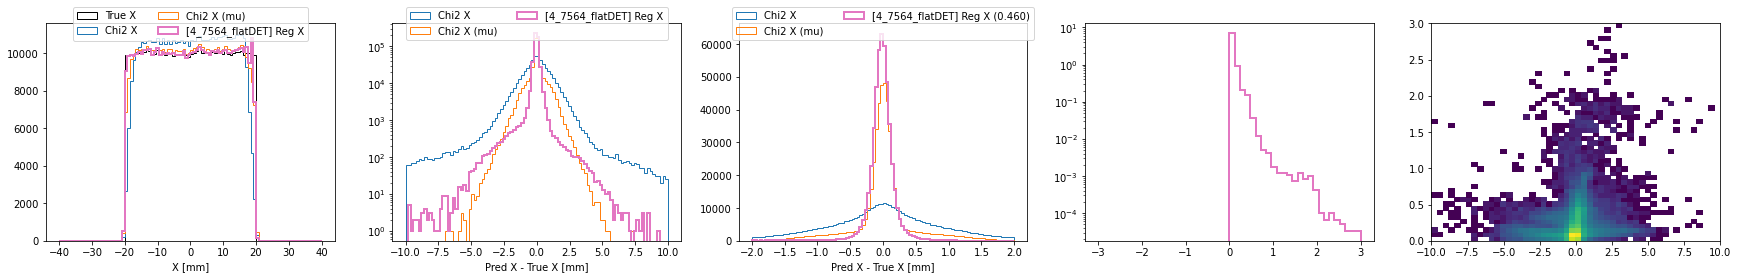

In [34]:
for mod in mdict:


    ncols, nrows = (5,1)
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(6*ncols,4*nrows))
    axs = axs.flatten()



    this_cut=(Y_mu==1)


    axs[0].hist(data['ev_mu_x'][this_cut], histtype='step', range=(-40,40), color='black',
                bins=100, label=f'True X')

    axs[0].hist(lfits[this_cut][:,1], histtype='step', range=(-40,40), color='C0',
                bins=100, label=f'Chi2 X')

    axs[0].hist(lfits_mu[this_cut][:,1], histtype='step', range=(-40,40), color='C1',
                bins=100, label=f'Chi2 X (mu)')

    axs[1].hist(lfits[this_cut][:,1] - data['ev_mu_x'][Y_mu==1], histtype='step', range=(-10,10), color='C0',
                bins=100, label=f'Chi2 X')

    axs[1].hist(lfits_mu[this_cut][:,1] - data['ev_mu_x'][Y_mu==1], histtype='step', range=(-10,10), color='C1',
                bins=100, label=f'Chi2 X (mu)')

    axs[2].hist(lfits[this_cut][:,1] - data['ev_mu_x'][Y_mu==1], histtype='step', range=(-2,2), color='C0',
                bins=100, label=f'Chi2 X')

    axs[2].hist(lfits_mu[this_cut][:,1] - data['ev_mu_x'][Y_mu==1], histtype='step', range=(-2,2), color='C1',
                bins=100, label=f'Chi2 X (mu)')

#     axs[3].hist(lfits[Y_mu==0][:,1], histtype='step', range=(-200,40), color='C0',
#                 bins=100, label=f'Chi2 X')

#     axs[3].hist(lfits_mu[Y_mu==0][:,1], histtype='step', range=(-200,40), color='C1',
#                 bins=100, label=f'Chi2 X (mu)')
    
    if 'x_reg' in mdict[mod]:
        
        xreg=mdict[mod]['x_reg']
        axs[0].hist(xreg[this_cut], histtype='step', range=(-40,40), bins=100, color=mdict[mod]['color'], 
                    label=f'[{mod}] Reg X', linewidth=2)
        
        axs[1].hist(xreg[this_cut] - data['ev_mu_x'][Y_mu==1], 
                    histtype='step', range=(-10,10), bins=100, color=mdict[mod]['color'], 
                    label=f'[{mod}] Reg X', linewidth=2)
        
        this_std = (xreg[this_cut] - data['ev_mu_x'][Y_mu==1]).std()
        axs[2].hist(xreg[this_cut] - data['ev_mu_x'][Y_mu==1], 
                    histtype='step', range=(-2,2), bins=100, color=mdict[mod]['color'], 
                    label=f'[{mod}] Reg X ({this_std:.3f})', linewidth=2)
        
        axs[3].hist(mdict[mod]['x_reg_dq'], 
                    histtype='step', range=(-3,3), bins=50, color=mdict[mod]['color'],  density=1,
                    label=f'[{mod}] Reg Angle', linewidth=2)
        
        axs[4].hist2d(
            xreg[this_cut] - data['ev_mu_x'][Y_mu==1],
            mdict[mod]['x_reg_dq'],
            range=( (-10, 10), (0, 3)),
            bins=(50,50),
            norm=mpl.colors.LogNorm()
        
        )
        
        
    axs[0].set_xlabel('X [mm]')
    axs[1].set_xlabel('Pred X - True X [mm]')
    axs[2].set_xlabel('Pred X - True X [mm]')
    axs[0].legend(ncol=2, loc='upper center', bbox_to_anchor=(0.5, 1.1))
    axs[1].legend(ncol=2, loc='upper center', bbox_to_anchor=(0.5, 1.1))
    axs[1].set_yscale('log')
    axs[2].legend(ncol=2, loc='upper center', bbox_to_anchor=(0.5, 1.1))
    axs[3].set_yscale('log')
    # plt.savefig(f"plots/{mod}_reg_0.pdf")
    plt.show()

In [35]:
for mod in mdict:
    if 'y_reg' not in mdict[mod]:
        continue

    ncols, nrows = (4,1)
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(6*ncols,4*nrows))
    axs = axs.flatten()



    this_cut=(Y_mu==1)


    axs[0].hist(data['ev_mu_y'][this_cut], histtype='step', range=(-40,40), color='black',
                bins=100, label=f'True Y')

    # axs[0].hist(lfits[this_cut][:,1], histtype='step', range=(-40,40), color='C0',
    #             bins=100, label=f'Chi2 Y')

    # axs[0].hist(lfits_mu[this_cut][:,1], histtype='step', range=(-40,40), color='C1',
    #             bins=100, label=f'Chi2 X (mu)')

    # axs[1].hist(lfits[this_cut][:,1] - data['ev_mu_x'][Y_mu==1], histtype='step', range=(-10,10), color='C0',
    #             bins=100, label=f'Chi2 X')

    # axs[1].hist(lfits_mu[this_cut][:,1] - data['ev_mu_x'][Y_mu==1], histtype='step', range=(-10,10), color='C1',
    #             bins=100, label=f'Chi2 X (mu)')

    # axs[2].hist(lfits[this_cut][:,1] - data['ev_mu_x'][Y_mu==1], histtype='step', range=(-2,2), color='C0',
    #             bins=100, label=f'Chi2 X')

    # axs[2].hist(lfits_mu[this_cut][:,1] - data['ev_mu_x'][Y_mu==1], histtype='step', range=(-2,2), color='C1',
    #             bins=100, label=f'Chi2 X (mu)')

    # axs[3].hist(lfits[Y_mu==0][:,1], histtype='step', range=(-200,40), color='C0',
    #             bins=100, label=f'Chi2 X')

    # axs[3].hist(lfits_mu[Y_mu==0][:,1], histtype='step', range=(-200,40), color='C1',
    #             bins=100, label=f'Chi2 X (mu)')
    
    if 'y_reg' in mdict[mod]:
        
        xreg=mdict[mod]['y_reg']
        axs[0].hist(xreg[this_cut], histtype='step', range=(-40,40), bins=100, color=mdict[mod]['color'], 
                    label=f'[{mod}] Reg X', linewidth=2)
        
        axs[1].hist(xreg[this_cut] - data['ev_mu_y'][Y_mu==1], 
                    histtype='step', range=(-10,10), bins=100, color=mdict[mod]['color'], 
                    label=f'[{mod}] Reg X', linewidth=2)
        
        this_std = (xreg[this_cut] - data['ev_mu_y'][Y_mu==1]).std()
        axs[2].hist(xreg[this_cut] - data['ev_mu_y'][Y_mu==1], 
                    histtype='step', range=(-2,2), bins=100, color=mdict[mod]['color'], 
                    label=f'[{mod}] Reg X ({this_std:.3f})', linewidth=2)
        
        axs[3].hist(xreg[Y_mu==0], 
                    histtype='step', range=(-200,40), bins=100, color=mdict[mod]['color'], 
                    label=f'[{mod}] Reg Y', linewidth=2)
        
        
    axs[0].set_xlabel('X [mm]')
    axs[1].set_xlabel('Pred X - True X [mm]')
    axs[2].set_xlabel('Pred X - True X [mm]')
    axs[0].legend(ncol=2, loc='upper center', bbox_to_anchor=(0.5, 1.1))
    axs[1].legend(ncol=2, loc='upper center', bbox_to_anchor=(0.5, 1.1))
    axs[1].set_yscale('log')
    axs[2].legend(ncol=2, loc='upper center', bbox_to_anchor=(0.5, 1.1))
    axs[2].set_yscale('log')
    # plt.savefig(f"plots/{mod}_reg_0.pdf")
    plt.show()

KeyError: 'yhat'

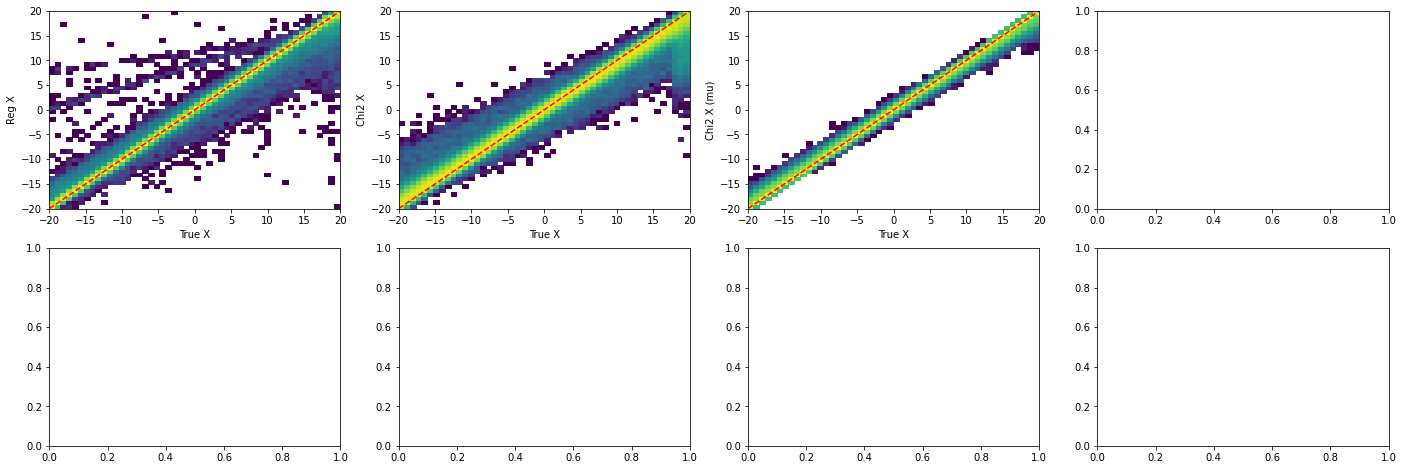

In [36]:
for mod in mdict:
    
    ncols, nrows = (4,2)
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(6*ncols,4*nrows))
    axs = axs.flatten()

    
    this_cut=(Y_mu==1)
    
    axs[0].hist2d( data['ev_mu_x'][this_cut], 
                   mdict[mod]['x_reg'][this_cut], 
                  range=((-20,20),(-20,20)),
                bins=(50,50),norm=mpl.colors.LogNorm())
    axs[0].set_xlabel('True X')
    axs[0].set_ylabel('Reg X')
    axs[0].plot([-20,20],[-20,20], 'r--')
    
    axs[1].hist2d( data['ev_mu_x'][this_cut], 
                   lfits[this_cut][:,1], 
                  range=((-20,20),(-20,20)),
                bins=(50,50),norm=mpl.colors.LogNorm())
    axs[1].set_xlabel('True X')
    axs[1].set_ylabel('Chi2 X')
    axs[1].plot([-20,20],[-20,20], 'r--')
    
    axs[2].hist2d( data['ev_mu_x'][this_cut], 
                   lfits_mu[this_cut][:,1], 
                  range=((-20,20),(-20,20)),
                bins=(50,50),norm=mpl.colors.LogNorm())
    axs[2].set_xlabel('True X')
    axs[2].set_ylabel('Chi2 X (mu)')
    axs[2].plot([-20,20],[-20,20], 'r--')
    
    axs[3].hist2d(mdict[mod]['yhat'][this_cut], 
                  mdict[mod]['x_reg'][this_cut],
                  range=((0.0,1), (-20,20)),
                bins=(50,50),norm=mpl.colors.LogNorm() )
    axs[3].set_xlabel('Y pred')
    axs[3].set_ylabel('Reg X')
    
    axs[4].hist2d(data['ev_mu_theta'][this_cut],
                  mdict[mod]['x_reg'][this_cut] - data['ev_mu_x'][this_cut], 
                  range=((-0.15, 0.15), (-1,1)),
                bins=(50,50),norm=mpl.colors.LogNorm() )
    axs[4].set_xlabel('Muon angle')
    axs[4].set_ylabel('Reg X - True X')
    
    if 'a_reg' in mdict[mod]:
        
        axs[5].hist2d(mdict[mod]['x_reg'][this_cut],
                      mdict[mod]['a_reg'][this_cut], 
                      range=((-25,25), (-0.15,0.15)),
                    bins=(50,50),norm=mpl.colors.LogNorm() )
        axs[5].set_xlabel('Muon angle')
        axs[5].set_ylabel('Reg X - True X')
    
    plt.savefig(f"plots/{mod}_reg_2d.pdf")
    plt.show()